This is the demo code for spatial regression graph convolutional neural networks (SRGCNN) and its Geographically Weighted variant (SRGCNN-GW)

Please cite the following paper if it helps:

[Zhu, D., Liu, Y., Yao, X., & Fischer, M. M. (2021). Spatial regression graph convolutional neural networks: A deep learning paradigm for spatial multivariate distributions. GeoInformatica, 1-32.](https://link.springer.com/article/10.1007/s10707-021-00454-x)

### 1. Import

SRGCNN models would require `pytorch` and `GPU` environment to implement. Spatial weights would require `PySAL` to construct (check out [here](https://pysal.org/spreg/api.html)). Please refer to this `import` section for package dependency.

- Original test environment:  `python 3.9.6`, `pytorch 1.9.0`, `cudatoolkit 10.2.89`
- Baseline spatial regression models are implemented following [the PySAL official documentation](https://pysal.org/spreg/api.html)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [87]:
import os
import math
import numpy as np, pandas as pd, math, torch
import matplotlib.pyplot as plt
import geopandas as gp
import copy
import seaborn as sns
###
import torch
from torch import nn
import torch.nn.functional as F
###
from pysal.lib import weights
import pysal as ps
import esda
import spreg
###
from scipy import sparse
from scipy.sparse import coo_matrix
from scipy.sparse import diags
from scipy.sparse import csr_matrix
from scipy.spatial import distance
from scipy.sparse import eye
from scipy import sparse
from scipy import stats
###
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import median_absolute_error as mae
from sklearn.neighbors import NearestNeighbors

In [6]:
# enable cuda gpu accelaration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
np.set_printoptions(suppress=True)

### 2. Functionalities

In [51]:
def mkdir(path):
    folder = os.path.exists(path)
    if not folder:                   
        os.makedirs(path)            
    else:
        print ("---  There exist a folder of the same name!  ---")
def row_normalize(mx):
    '''Row-normalize sparse matrix'''
    rowsum = np.array(mx.sum(1))
    r_inv = (rowsum ** -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx
def unlog(x):
    '''return x to the power of 10'''
    return pow(10,x)

def step(model,optimizer,input_tensor,idx,target_tensor): ##idx: use ids in the training set
    '''
    train with element-wise loss vector，return the mean scalar of the loss
    '''
    with torch.autograd.set_detect_anomaly(True):
        model.train()
        optimizer.zero_grad()
        output = model(input_tensor, adj)
        loss = F.mse_loss(output[idx], target_tensor[idx],reduce=False)
        loss.backward(torch.reshape(torch.ones(len(idx)).to(device),(len(idx),1)),retain_graph=False)
        optimizer.step()
        return loss.mean().item()

def evaluate(model,input_tensor,idx,target_tensor):## idx: use ids in the validation set
    '''
    Monitor the loss of validation set during the training
    '''
    model.eval()
    output = model(input_tensor, adj)
    loss = F.mse_loss(output[idx], target_tensor[idx],reduce=False)
    return loss.mean().item()

def evaluate_MAE(model,input_tensor,idx,target_tensor):## idx: use ids in the training set
    '''
    Monitor the Mean abosolute error of validation set during the training
    '''
    model.eval()
    output = model(input_tensor, adj)
    loss = F.l1_loss(output[idx], target_tensor[idx],reduce=False)
    return loss.mean().item()

def evaluate_MAPE(model,input_tensor,idx,target_tensor):## idx: use ids in the validation set
    '''
    Monitor the Mean abosolute percentage error of validation set during the training
    '''
    model.eval()
    output = model(input_tensor, adj)
    MAPE = F.l1_loss(output[idx], target_tensor[idx],reduce=False)/target_tensor[idx]
    return MAPE.mean().item() 

def return_results(model,input_tensor,idx,target_tensor): ## return results as arrays
    '''
    call a model and get the predicted array and the ground truth array
    '''
    model.eval()
    output = model(input_tensor, adj)
    return output[idx].cpu().detach().numpy(),target_tensor[idx].cpu().detach().numpy()

### 3. Models

In [83]:
class GraphConvolution(nn.Module):
    """Basic graph convolution operation that incorporate both spatial lagged X 
    and spatial lagged Y (to be used in the basic SRGCNNs model)"""
    def __init__(self, f_in, f_out, use_bias=True, activation=F.relu):#hidden layer with relu activation
        super().__init__()
        self.f_in = f_in
        self.f_out = f_out
        self.use_bias = use_bias
        self.activation = activation
        self.weight = nn.Parameter(torch.FloatTensor(f_in, f_out),requires_grad=True)###requires_grad:whether allow weights to be updated
        self.bias = nn.Parameter(torch.FloatTensor(f_out)) if use_bias else None
        self.initialize_weights()
    
    def initialize_weights(self):
        nn.init.constant_(self.weight,1)
        if self.use_bias: nn.init.constant_(self.bias,0)
        
    def forward(self, input, adj):
##      ---- self.method=='SRGCNN':
        support = torch.mm(input, self.weight)
        output = torch.mm(adj, support) #adj here has to be renormalized     
        
        
        if self.use_bias: output.add_(self.bias)
        if self.activation is not None: output=self.activation(output) 
        
        return output
    
class GWGraphConvolution(nn.Module):
    """Geographically weighted graph convolution operation that 
    adds locally parameterized weights to all the variables (to be used in the SRGCNNs-GW model)"""
    def __init__(self, f_in, f_out, use_bias=True, activation=F.relu):# hidden layer with relu activation
        super().__init__()
        self.f_in = f_in
        self.f_out = f_out
        self.use_bias = use_bias
        self.activation = activation
        #########Geographically local parameters
        self.gwr_weight = nn.Parameter(torch.FloatTensor(db.shape[0], f_in),requires_grad=True)
        self.weight = nn.Parameter(torch.FloatTensor(f_in, f_out),requires_grad=True)###requires_grad:whether allow weights to be updated
        self.bias = nn.Parameter(torch.FloatTensor(f_out)) if use_bias else None
        self.initialize_weights()
    
    def initialize_weights(self):
        nn.init.constant_(self.weight,1)
        nn.init.constant_(self.gwr_weight,1)
        if self.use_bias: nn.init.constant_(self.bias,0)
        
    def forward(self, input, adj):            
#         ---- self.method=='SRGCNN-GW':
        gwr_support=torch.mul(input,self.gwr_weight) # use torch.mul to enable element-wise product
        support=torch.mm(adj,gwr_support) #adj here has to be renormalized     
        output=torch.mm(support,self.weight)
        
        if self.use_bias: output.add_(self.bias)
        if self.activation is not None: output=self.activation(output)
        
        return output

class GCN(nn.Module):
    """Basic SRGCNN model"""
    def __init__(self, f_in, n_classes, hidden=[16], dropouts=[0.0]):
        if hidden==[]:
            super().__init__()
            self.layers=[]
            self.dropouts=[]
            self.out_layer = GraphConvolution(f_in, n_classes, activation=None)# for spatial regression tasks: no activation func after the output layer
        else:
            super().__init__()
            layers = []
            for f_in,f_out in zip([f_in]+hidden[:-1], hidden):
                layers += [GraphConvolution(f_in, f_out)]

            self.layers = nn.Sequential(*layers)
            self.dropouts = dropouts
            self.out_layer = GraphConvolution(f_out, n_classes, activation=None)# for spatial regression tasks: no activation func after the output layer
    
        
    def forward(self, x, adj):
        for layer,d in zip(self.layers, self.dropouts):
            x = layer(x, adj)
            if d > 0: F.dropout(x, d, training=self.training, inplace=True)
                
        return self.out_layer(x, adj)
    
class GWGCN(nn.Module):
    """SRGCNN-GW model"""
    def __init__(self, f_in, n_classes, hidden=[16], dropouts=[0.0]):
        if hidden==[]:
            super().__init__()
            self.layers=[]
            self.dropouts=[]
            self.out_layer = GWGraphConvolution(f_in, n_classes, activation=None)# for spatial regression tasks: no activation func after the output layer
        else:
            super().__init__()
            layers = []
            for f_in,f_out in zip([f_in]+hidden[:-1], hidden):
                layers += [GWGraphConvolution(f_in, f_out)]

            self.layers = nn.Sequential(*layers)
            self.dropouts = dropouts
            self.out_layer = GWGraphConvolution(f_out, n_classes, activation=None)# for spatial regression tasks: no activation func after the output layer     
    def forward(self, x, adj):
        for layer,d in zip(self.layers, self.dropouts):
            x = layer(x, adj)
            if d > 0: F.dropout(x, d, training=self.training, inplace=True)
                
        return self.out_layer(x, adj)


### 4. Case Data 
(For this open repository, we only show the airbnb case described in the Appendix section of paper)

In [11]:
db = gp.read_file('./airbnb/regression_db.geojson')
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6110 entries, 0 to 6109
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   accommodates        6110 non-null   int64   
 1   bathrooms           6110 non-null   float64 
 2   bedrooms            6110 non-null   float64 
 3   beds                6110 non-null   float64 
 4   neighborhood        6110 non-null   object  
 5   pool                6110 non-null   int64   
 6   d2balboa            6110 non-null   float64 
 7   coastal             6110 non-null   int64   
 8   price               6110 non-null   float64 
 9   log_price           6110 non-null   float64 
 10  id                  6110 non-null   int64   
 11  pg_Apartment        6110 non-null   int64   
 12  pg_Condominium      6110 non-null   int64   
 13  pg_House            6110 non-null   int64   
 14  pg_Other            6110 non-null   int64   
 15  pg_Townhouse        6110 non-n

In [12]:
# the basic independent variables used for regression
variable_names = [
    'accommodates', 
    'bathrooms', 
    'bedrooms', 
    'beds'
]
# the appended independent variables used for regression (may be used for feature engineering)
variable_names_append = [
    'accommodates', 
    'bathrooms', 
    'bedrooms', 
    'beds', 
    'rt_Private_room', 
    'rt_Shared_room',
    'pg_Condominium', 
    'pg_House', 
    'pg_Other', 
    'pg_Townhouse',
    'coastal'
]

<AxesSubplot:>

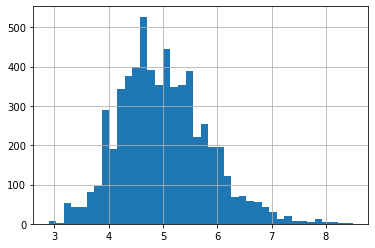

In [13]:
db.log_price.hist(bins=40)

<AxesSubplot:>

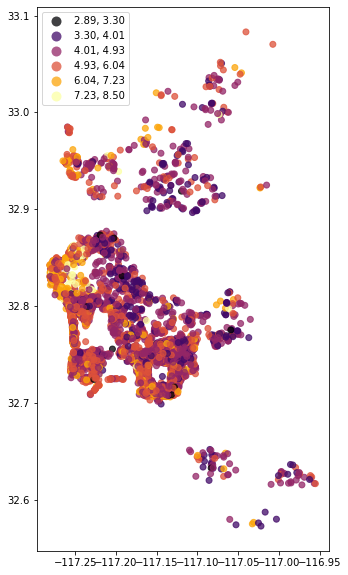

In [15]:
f,ax=plt.subplots(1,1,figsize=(10,10))
db.plot(column='log_price',cmap='inferno',scheme='percentiles',alpha=0.75,legend=True,ax=ax)

### 4. Settings

Spatial weights, variables and hyperparameters

In [60]:
knn=weights.KNN.from_dataframe(db, k=20)
def knn_adj(data=db,k=20):
    knn=weights.KNN.from_dataframe(data, k=20)
    knn_full_2darray=knn.full()[0]
    Laplacian_knn=torch.FloatTensor(row_normalize(knn_full_2darray))
    return Laplacian_knn

In [24]:
### The variable name for the graph structure needs to be named as adj (see the class of GraphConvolution)
adj=knn_adj(db,20).to(device)

In [43]:
### The observations for data regression
x_tensor=torch.FloatTensor(db[variable_names].values.tolist()).to(device)
x_append_tensor=torch.FloatTensor(db[variable_names_append].values.tolist()).to(device)
y_tensor=torch.FloatTensor(db[['log_price']].values.tolist()).to(device)
idx_all=torch.LongTensor(db.index.values).to(device)

In [85]:
### Params settings for the model on limited Xs
n_labels = 1 # #output feature dimension:log_price
n_features = len(variable_names)# #input feature dimensional vector
epochs = 18000 # #max training epoch
lr = 3e-2 ##learning rate

### 5. Train the Model
Only show the case for SRGCNN-GW; try `model=GCN(...)` for the basic SRGCNN model; try replace `x_tensor` with `x_append_tensor` for another scenario of independent variables 

In [ ]:
model=GWGCN(n_features,n_labels,hidden=[8*n_features],dropouts=[0.5]).to(device)
optimizer=torch.optim.Adam(filter(lambda p: p.requires_grad,model.parameters()),lr,weight_decay=lr)
lowest_mean_global_MAPE=99999.0
min_global_MAPE_epoch=-1
train_loss_arr=[]
mape_arr=[]
for i in range(0,epochs):
    train_loss=step(model,optimizer,x_tensor,idx_all,y_tensor) ## For demo, train with all ids "idx_all"
    train_loss_arr.append(train_loss)
    global_MAPE=evaluate_MAPE(model,x_tensor,idx_all,y_tensor) ## For demo, evaluate with again all ids "idx_all"
    mape_arr.append(global_MAPE*100)

    if global_MAPE<lowest_mean_global_MAPE:
        lowest_mean_global_MAPE=global_MAPE
        output,target=return_results(model,x_tensor,idx_all,y_tensor)##############
        min_global_MAPE_epoch=i

    if i%1000==0 or i==epochs-1:
        print("epoch:"+str(i)+"--train_loss:"+str(train_loss))
        print(" --global_MAPE:"+'{:.4f}%'.format(global_MAPE*100))

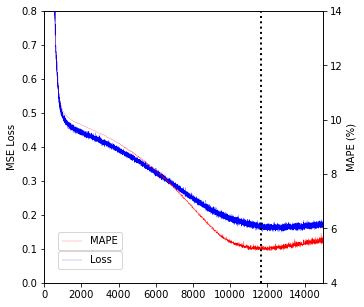

In [63]:
f,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(train_loss_arr,lw=0.2,color='b',alpha=1,label='Loss  ')
ax.set_xlim([0,15000])
ax.set_ylim([0,0.8])
ax2=ax.twinx()
ax2.plot(mape_arr,lw=0.2,color='r',alpha=1,label='MAPE')
ax2.set_ylim([4,14])
ax2.legend(loc=(0.05,0.12))
ax.legend(loc=(0.05,0.05))
ax.set_ylabel('MSE Loss')
ax2.set_ylabel('MAPE (%)')
plt.axvline(min_global_MAPE_epoch, linestyle="dotted", linewidth=2, color='black')

### 6. Output Statistics

The best results are recorded in the output array

In [56]:
mape=(mae(output,target)/target).mean()
mape # mean absolute percentage error between predicted y and the real y

0.04202389

Model goodness of fit

In [58]:
SSE=np.sum((target-output)**2)
SST=np.sum((db[['log_price']].values-db[['log_price']].values.mean())**2)

Rsq=1-SSE/SST
Rsq # R-square of model fit

0.8293636638139943

Moran's I of the model errors

In [61]:
Ierror = esda.moran.Moran(output-target, knn)
print('Errors  moransI: '+str(Ierror.I)+'  Z_I: '+str(Ierror.z_norm)+' p-value: '+str(Ierror.p_sim))

Errors  moransI: 0.06294708054651167  Z_I: 16.464498168930206 p-value: 0.001


### 7. Visualization

Text(0.5, 1.0, 'error')

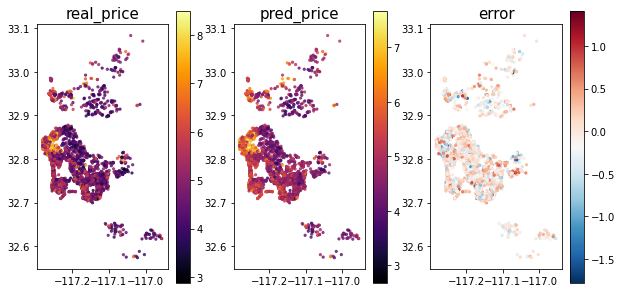

In [101]:
dbplot=db.loc[:,['log_price','geometry']].copy()
dbplot['pred']=output
dbplot['error']=output-db[['log_price']].values

f,ax=plt.subplots(1,3,figsize=(10,5))

dbplot.plot(column='log_price',cmap='inferno',s=5,alpha=0.75,legend=True,ax=ax[0])
dbplot.plot(column='pred',cmap='inferno',s=5,alpha=0.75,legend=True,ax=ax[1])
dbplot.plot(column='error',cmap='RdBu_r',s=5,alpha=1,legend=True,ax=ax[2])
ax[0].set_title('real_price',fontsize=15)
ax[1].set_title('pred_price',fontsize=15)
ax[2].set_title('error',fontsize=15)

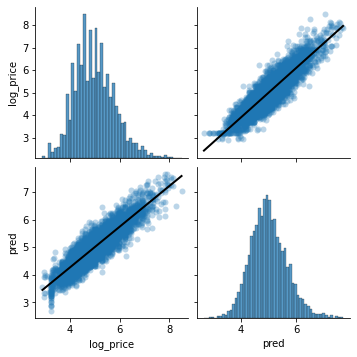

In [100]:
sns.pairplot(dbplot.drop('error',axis=1),diag_kind="hist",\
             kind='reg',plot_kws={'line_kws':{'color':'black','lw':2}, 'scatter_kws': {'linewidth':0,'alpha': 0.3}})